# The Fake Cereal Problem

In [17]:
%matplotlib inline

import pyblp
import numpy as np
import matplotlib.pyplot as plt

pyblp.options.digits = 3
pyblp.options.verbose = False
np.set_printoptions(precision=2, threshold=10, linewidth=100)

In this tutorial, we'll use data from [Nevo (2000)](../../references.rst#nevo-2000) to solve the paper's fake cereal problem. Locations of CSV files that contain the data are in the `pyblp.data` module.

## Configuring Data

The `product_data` argument of `pyblp.Problem` should be a structured array-like object with fields that store data. Product data can be a structured `pyblp.numpy.ndarray`, a `pyblp.pandas.DataFrame`, or other similar objects. We'll use `numpy` to read the data.

In [4]:
product_data = np.recfromcsv(pyblp.data.NEVO_PRODUCTS_LOCATION, encoding='utf-8')
product_data.dtype.names

('market_ids',
 'city_ids',
 'quarter',
 'product_ids',
 'firm_ids0',
 'firm_ids1',
 'brand_ids',
 'shares',
 'prices',
 'sugar',
 'mushy',
 'demand_instruments0',
 'demand_instruments1',
 'demand_instruments2',
 'demand_instruments3',
 'demand_instruments4',
 'demand_instruments5',
 'demand_instruments6',
 'demand_instruments7',
 'demand_instruments8',
 'demand_instruments9',
 'demand_instruments10',
 'demand_instruments11',
 'demand_instruments12',
 'demand_instruments13',
 'demand_instruments14',
 'demand_instruments15',
 'demand_instruments16',
 'demand_instruments17',
 'demand_instruments18',
 'demand_instruments19')

The product data contains market IDs, product IDs, two sets of firm IDs (the second are IDs after a simple merger, which are used later), shares, prices, a number of product characteristics, and some pre-computed excluded instruments. The product IDs will be used to construct fixed effects. For more information about the instruments and the example data as a whole, refer to the `pyblp.data` module.

The `agent_data` argument of `pyblp.Problem` should also be a structured array-like object.

In [5]:
agent_data = np.recfromcsv(pyblp.data.NEVO_AGENTS_LOCATION, encoding='utf-8')
agent_data.dtype.names

('market_ids',
 'city_ids',
 'quarter',
 'weights',
 'nodes0',
 'nodes1',
 'nodes2',
 'nodes3',
 'income',
 'income_squared',
 'age',
 'child')

The agent data contains market IDs, integration weights, integration nodes, and demographics. In non-example problems, it is usually a better idea to use many more draws, or a more sophisticated `pyblp.Integration` configuration such as sparse grid quadrature.


## Solving the Problem

Formulations, product data, and either agent data or an integration configuration are collectively used to initialize a `pyblp.Problem`. Once initialized, `pyblp.Problem.solve` runs the estimation routine. The arguments to `pyblp.Problem.solve` configure how estimation is performed. For example, `optimization` and `iteration` arguments configure the optimization and iteration routines that are used by the outer and inner loops of estimation.

Up to four `pyblp.Formulation` configurations can be used to configure a `pyblp.Problem`. For the fake cereal problem, we'll specify formulations for $X_1$, $X_2$, and $d$. The formulation for $X_1$ consists of prices and product fixed effects, which we will absorb into $X_1$ with the `absorb` argument of `pyblp.Formulation`.  Since `sugar` and `mushy` are collinear with `product_ids`, it's okay to only include them in $X_2$.

In [8]:
product_formulations = (
   pyblp.Formulation('0 + prices', absorb='C(product_ids)'),
   pyblp.Formulation('1 + prices + sugar + mushy')
)
product_formulations

(prices + Absorb[C(product_ids)], 1 + prices + sugar + mushy)

In [9]:
agent_formulation = pyblp.Formulation('0 + income + income_squared + age + child')
agent_formulation

income + income_squared + age + child

In [11]:
problem = pyblp.Problem(product_formulations, product_data, agent_formulation, agent_data)
problem

Dimensions:
   N:       T:              K1:                       K2:                     K3:                D:              MD:                 MS:             ED:         ES:            H:      
Products  Markets  Linear Characteristics  Nonlinear Characteristics  Cost Characteristics  Demographics  Demand Instruments  Supply Instruments  Demand FEs  Supply FEs  Nesting Groups
--------  -------  ----------------------  -------------------------  --------------------  ------------  ------------------  ------------------  ----------  ----------  --------------
  2256      94               1                         4                       0                 4                20                  0               1           0             0       

Formulations:
       Column Indices:           0           1           2      3  
-----------------------------  ------  --------------  -----  -----
 X1: Linear Characteristics    prices                              
X2: Nonlinear Characteristics

If we were interested in estimates for each product, we could replace the formulation for $X_1$ with `pyblp.Formulation('prices + C(product_ids)')`. Absorption of fixed effects yields the same first-stage results as does including them as indicator variables, although results for GMM stages after the first may be slightly different because the two methods can give rise to different weighting matrices.

Inspecting the attributes of the `pyblp.Problem` instance helps to confirm that the problem has been configured correctly. For example, inspecting `pyblp.Problem.products` and `pyblp.Problem.agents` confirms that product data were structured correctly and that agent data were built correctly.

In [12]:
problem.products

rec.array([(['C01Q1'], [1, 1], ['F1B04'], [], [], [], [], [0.01], [-2.50e-01,  4.09e-02, -1.58e+00, -2.69e-01, -1.00e-02,  6.93e-03, -9.22e-01,  5.11e-03,  1.28e-01,  2.79e-01,  1.98e-01,  2.46e-01, -4.14e-03, -3.56e-02,  7.06e-02,  1.18e-02,  1.73e-02, -1.50e-02,  8.12e-02, -1.58e-02], [], [-0.01], [ 1.  ,  0.07,  2.  ,  1.  ], [], [0.07], [ 2.], [1.]),
           (['C01Q1'], [1, 1], ['F1B06'], [], [], [], [], [0.01], [-2.06e-01,  5.71e-02, -1.04e+01,  1.50e-01,  3.98e-02,  6.06e-03,  1.09e+00,  8.56e-02,  1.13e-01, -2.69e-02, -1.18e+00, -1.28e-01,  2.58e-03, -6.78e-03, -4.55e-02,  6.69e-05,  3.12e-02,  5.84e-03, -3.21e-02, -1.06e-02], [], [-0.01], [ 1.  ,  0.11, 18.  ,  1.  ], [], [0.11], [18.], [1.]),
           (['C01Q1'], [1, 1], ['F1B07'], [], [], [], [], [0.01], [-2.12e-01,  4.62e-02, -2.28e+00, -3.00e-02,  2.39e-03, -1.32e-02,  3.31e-01, -1.73e-01, -2.26e-01,  3.13e-01,  1.04e+00,  1.99e-01,  9.92e-04,  1.84e-02,  8.16e-02,  3.50e-02,  2.79e-02,  1.32e-02,  4.75e-02,  2.68e-02]

In [13]:
problem.agents

rec.array([(['C01Q1'], [0.05], [ 4.34e-01, -1.50e+00, -1.15e+00,  1.61e-01], [ 4.95e-01,  8.33e+00, -2.30e-01, -2.31e-01]),
           (['C01Q1'], [0.05], [-7.27e-01,  1.33e-01, -5.01e-01,  1.30e-01], [ 3.79e-01,  6.12e+00, -2.53e+00,  7.69e-01]),
           (['C01Q1'], [0.05], [-6.23e-01, -1.38e-01,  7.97e-01, -7.96e-01], [ 1.05e-01,  1.03e+00, -6.97e-03, -2.31e-01]),
           ...,
           (['C65Q2'], [0.05], [-1.42e+00, -7.30e-01,  6.97e-01,  7.49e-01], [ 8.92e-01,  1.61e+01,  2.71e-01, -2.31e-01]),
           (['C65Q2'], [0.05], [ 3.20e-01,  1.57e-01,  1.35e+00,  1.77e+00], [-2.96e+00, -4.57e+01, -1.84e+00,  7.69e-01]),
           (['C65Q2'], [0.05], [ 7.83e-01, -2.39e-01, -7.36e-04, -2.10e+00], [-5.17e-01, -9.98e+00, -1.84e+00,  7.69e-01])],
          dtype=[('market_ids', 'O', (1,)), ('weights', '<f8', (1,)), ('nodes', '<f8', (4,)), (((income, income_squared, age, child), 'demographics'), '<f8', (4,))])

The initialized problem can be solved with `pyblp.Problem.solve`. We'll use the same starting values as [Nevo (2000)](../../references.rst#nevo-2000). By passing a diagonal matrix of ones as starting values for $\Sigma$, we're choosing to optimize over only variance terms. Similarly, zeros in the starting values for $\Pi$ mean that those parameters will be fixed at zero. To solve the problem, we'll use a non-default unbounded optimization routine that is similar to the default one in Matlab often used to replicate the paper.

In [16]:
initial_sigma = np.diag([0.3302, 2.4526, 0.0163, 0.2441])
initial_pi = [
  [ 5.4819,  0,      0.2037,  0     ],
  [15.8935, -1.2000, 0,       2.6342],
  [-0.2506,  0,      0.0511,  0     ],
  [ 1.2650,  0,     -0.8091,  0     ]
]
results = problem.solve(
   initial_sigma,
   initial_pi,
   optimization=pyblp.Optimization('bfgs')
)
results

Problem Results Summary:
Cumulative  GMM   Optimization   Objective   Total Fixed Point  Total Contraction  Objective    Gradient   
Total Time  Step   Iterations   Evaluations     Iterations         Evaluations       Value    Infinity Norm
----------  ----  ------------  -----------  -----------------  -----------------  ---------  -------------
 0:00:27     2         25           54             24672              78616        +1.38E+04    +1.29E-04  

Linear Estimates (Robust SEs in Parentheses):
Beta:    prices   
-----  -----------
        -6.03E+01 
       (+1.37E+01)

Nonlinear Estimates (Robust SEs in Parentheses):
Sigma:       1         prices        sugar        mushy     |   Pi:      income     income_squared      age         child   
------  -----------  -----------  -----------  -----------  |  ------  -----------  --------------  -----------  -----------
  1      +5.45E-01    +0.00E+00    +0.00E+00    +0.00E+00   |    1      +2.26E+00     +0.00E+00      +1.32E+00    +0.00E

Results are similar to those in the original paper. Note that one of the estimated terms on the diagonal of $\Sigma$ is negative. Since the diagonal consists of standard deviations, negative values are unrealistic. When using another optimization routine (like the default L-BFGS-B routine) that supports bounds, these diagonal elements are by default bounded from below by zero. In the next example we'll use the default routine.


## Problem Results

The `pyblp.Problem.solve` method returns a `pyblp.ProblemResults` class, which, when printed, displays basic estimation results. The results that are displayed are simply formatted information extracted from various class attributes such as `pyblp.ProblemResults.sigma` and `pyblp.ProblemResults.sigma_se`.

Additional post-estimation outputs can be computed with `pyblp.ProblemResults` methods.


### Elasticities and Diversion Ratios

We can estimate elasticities, $\varepsilon$, and diversion ratios, $\mathscr{D}$, with `pyblp.ProblemResults.compute_elasticities` and `pyblp.ProblemResults.compute_diversion_ratios`.

In [18]:
elasticities = results.compute_elasticities()
ratios = results.compute_diversion_ratios()

Post-estimation outputs are computed for each market and stacked. We'll use `matplotlib.pyplot.matshow` and `matplotlib.pyplot.colorbar` to display the matrices associated with a single market.

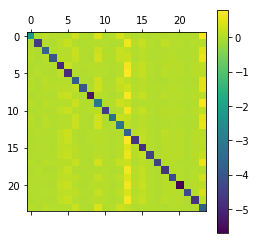

In [20]:
single_market = nevo_product_data['market_ids'] == 'C01Q1'
plt.colorbar(plt.matshow(elasticities[single_market]));

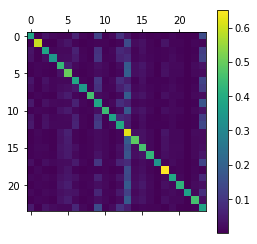

In [21]:
plt.colorbar(plt.matshow(ratios[single_market]));

The diagonal of the first image consists of own elasticities and the diagonal of the second image consists of diversion ratios to the outside good.

Elasticities and diversion ratios can be computed with respect to variables other than `prices` with the `name` argument of `pyblp.ProblemResults.compute_elasticities` and `pyblp.ProblemResults.compute_diversion_ratios`. Additionally, the `pyblp.ProblemResults.compute_long_run_diversion_ratios` can be used to used to understand substitution when products are eliminated from the choice set.

The convenience methods `pyblp.ProblemResults.extract_diagonals` and `pyblp.ProblemResults.extract_diagonal_means` can be used to extract information about own elasticities of demand from elasticity matrices.

In [23]:
means = results.extract_diagonal_means(elasticities)

An alternative to summarizing full elasticity matrices is to use `pyblp.ProblemResults.compute_aggregate_elasticities` to estimate aggregate elasticities of demand, $E$, in each market, which reflect the change in total sales under a proportional sales tax of some factor.

In [24]:
aggregates = results.compute_aggregate_elasticities(factor=0.1)

Since demand for an entire product category is generally less elastic than the average elasticity of individual products, mean own elasticities are generally larger in magnitude than aggregate elasticities.

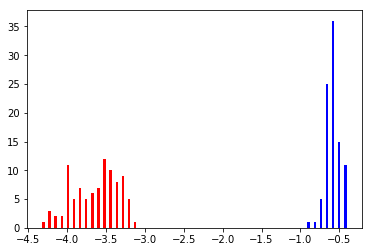

In [45]:
plt.hist([means.flatten(), aggregates.flatten()], color=['red', 'blue'], bins=50);

### Marginal Costs and Markups

To compute marginal costs, $c$, the `product_data` passed to `pyblp.Problem` must have had a `firm_ids` field. Since we included firm IDs when configuring the problem, we can use `pyblp.ProblemResults.compute_costs`.

In [32]:
costs = results.compute_costs()

Other methods that compute supply-side outputs often compute marginal costs themselves. For example, `pyblp.ProblemResults.compute_markups` will compute marginal costs when estimating markups, $\mathscr{M}$, but computation can be sped up if we just use our pre-computed values.

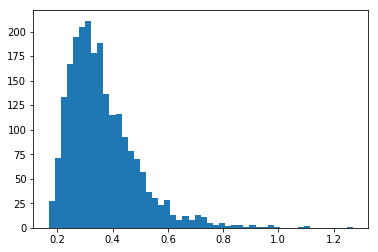

In [36]:
markups = results.compute_markups(costs=costs)
plt.hist(markups, bins=50);

### Mergers

Before computing post-merger outputs, we'll supplement our pre-merger markups with some other outputs. We'll compute Herfindahl-Hirschman Indices, $\text{HHI}$, with `pyblp.ProblemResults.compute_hhi`; population-normalized gross expected profits, $\pi$, with `pyblp.ProblemResults.compute_profits`; and population-normalized consumer surpluses, $\text{CS}$, with `pyblp.ProblemResults.compute_consumer_surpluses`.

In [37]:
hhi = results.compute_hhi()
profits = results.compute_profits(costs=costs)
cs = results.compute_consumer_surpluses()

To compute post-merger outputs, the `firm_ids` field in the `product_data` passed to `pyblp.Problem` must have had at least two columns. Columns after the first represent changes, such as mergers. Although mergers are commonly what firm ID changes represent, these additional columns can represent any type of change.

Since we included two columns of firm IDs when configuring the problem, we can use `pyblp.ProblemResults.compute_approximate_prices` or `pyblp.ProblemResults.compute_prices` to estimate post-merger prices. The first method, which is discussed, for example, in [Nevo (1997)](../../references.rst#nevo-1997), assumes that shares and their price derivatives are unaffected by the merger. The second method does not make these assumptions and iterates over the $\zeta$-markup equation from [Morrow and Skerlos (2011)](../../references.rst#morrow-and-skerlos-2011) to solve the full system of $J_t$ equations and $J_t$ unknowns in each market $t$. We'll use the latter, since it is fast enough for this example problem.

In [39]:
changed_prices = results.compute_prices(costs=costs)

If the problem was configured with more than two columns of firm IDs, we could estimate post-merger prices for the other mergers with the `firms_index` argument, which is by default `1`.

We'll compute post-merger shares with `pyblp.ProblemResults.compute_shares`.

In [40]:
changed_shares = results.compute_shares(changed_prices)

Post-merger prices and shares are used to compute other post-merger outputs. For example, $\text{HHI}$ increases.

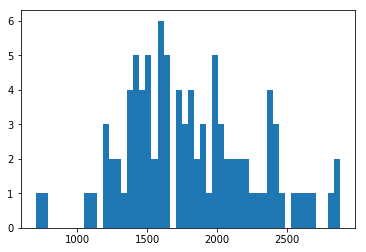

In [41]:
changed_hhi = results.compute_hhi(firms_index=1, shares=changed_shares)
plt.hist(changed_hhi - hhi, bins=50);

Markups, $\mathscr{M}$, and profits, $\pi$, generally increase as well.

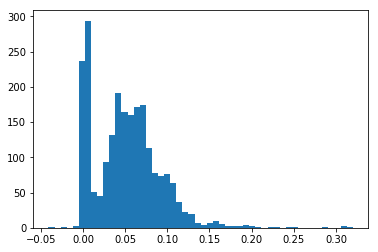

In [42]:
changed_markups = results.compute_markups(changed_prices, costs)
plt.hist(changed_markups - markups, bins=50);

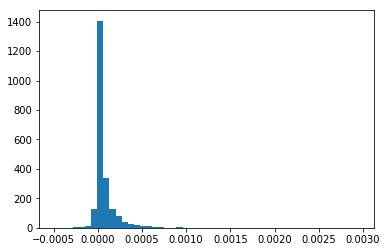

In [43]:
changed_profits = results.compute_profits(changed_prices, changed_shares, costs)
plt.hist(changed_profits - profits, bins=50);

On the other hand, consumer surpluses, $\text{CS}$, generally decrease.

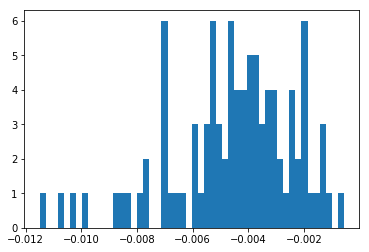

In [44]:
changed_cs = results.compute_consumer_surpluses(changed_prices)
plt.hist(changed_cs - cs, bins=50);

## Bootstrapping Results

Post-estimation outputs can be informative, but they don't mean much without a sense sample-to-sample variability. One way to estimate confidence intervals for post-estimation outputs is with a standard bootstrap procedure:

1. Construct a large number of bootstrap samples by sampling with replacement from the original product data.
2. Initialize and solve a `pyblp.Problem` for each bootstrap sample.
3. Compute the desired post-estimation output for each bootstrapped `pyblp.ProblemResults` and from the resulting empirical distribution, construct boostrap confidence intervals.

Although appealing because of its simplicity, the computational resources required for this procedure are often prohibatively expensive. Furthermore, human oversight of the optimization routine is often required to determine whether the routine ran into any problems and if it successfully converged. Human oversight of estimation for each bootstrapped problem is usually not feasible.

A more reasonable alternative is a parametric bootstrap procedure:

1. Construct a large number of draws from the estimated joint distribution of parameters.
2. Compute the implied mean utility, $\delta$, and shares, $s$, for each draw. If a supply side was estimated, also computed the implied marginal costs, $c$, and prices, $p$.
3. Compute the desired post-estimation output under each of these parametric bootstrap samples. Again, from the resulting empirical distribution, construct boostrap confidence intervals.

Compared to the standard bootstrap procedure, the parametric bootstrap requires far fewer computational resources, and is simple enough to not require human oversight of each bootstrap iteration. The primary complication to this procedure is that when supply is estimated, equilibrium prices and shares need to be computed for each parametric bootstrap sample by iterating over the $\zeta$-markup equation from [Morrow and Skerlos (2011)](../../references.rst#morrow-and-skerlos-2011). Although nontrivial, this fixed point iteration problem is much less demanding than the full optimization routine required to solve the BLP problem from the start.

An empirical distribution of results computed according to this parametric bootstrap procedure can be created with the `pyblp.ProblemResults.bootstrap` method, which returns a `pyblp.BootstrappedProblemResults` class that can be used just like `pyblp.ProblemResults` to compute various post-estimation outputs. The difference is that `pyblp.BootstrappedProblemResults` methods return arrays with an extra first dimension, along which bootstrapped results are stacked.

We'll construct 90% parametric bootstrap confidence intervals for estimated consumer surpluses in each market of the fake cereal problem. Usually, bootstrapped confidence intervals should be based on thousands of draws, but we'll only use a few for the sake of speed in this example.

In [47]:
bootstrapped_results = results.bootstrap(draws=50, seed=0)
bootstrapped_results

Bootstrapped Problem Results Summary:
Computation  Bootstrap
   Time        Draws  
-----------  ---------
  0:00:02       50    

In [49]:
cs_ci = np.percentile(bootstrapped_results.compute_consumer_surpluses(), q=[10, 90], axis=0)
np.c_[cs_ci[0], cs, cs_ci[1]]

array([[-0.29,  0.02,  0.21],
       [-0.27,  0.03,  0.05],
       [-0.37,  0.03,  0.17],
       ...,
       [-0.28,  0.05,  0.14],
       [-0.24,  0.02,  0.16],
       [-0.25,  0.02,  0.16]])

## Optimal Instruments

Given a consistent estimate of $\theta$, we may want to compute [Chamberlain's (1987)](../../references.rst#chamberlain-1987) optimal instruments and use them to re-solve the problem. Optimal instruments have been shown, for example, by [Reynaert and Verboven (2014)](../../references.rst#reynaert-and-verboven-2014), to reduce bias, improve efficiency, and enhance stability of BLP estimates.

The `pyblp.ProblemResults.compute_optimal_instruments` method computes the expected Jacobians that comprise the optimal instruments by integrating over the density of $\xi$ (and $\omega$ if a supply side was estimated). Since we didn't specify a supply side in the fake cereal problem, we need to supply an estimate of $\operatorname{\mathbb{E}}[p \mid Z]$. We'll use the convenience function `pyblp.compute_fitted_values` to estimate this vector with a reduced form regression of endogenous prices onto the full set of instruments: excluded instruments and the absorbed product IDs that constitute $X_1$.

In [50]:
instrument_formulation = pyblp.Formulation(
    ' + '.join(f'demand_instruments{i}' for i in range(20)), 
    absorb='C(product_ids)'
)
expected_prices = pyblp.compute_fitted_values(
    product_data['prices'],
    instrument_formulation,
    product_data
)

By default, `pyblp.ProblemResults.compute_optimal_instruments` approximates an integral over the density of the error terms by averaging over Jacobian realizations computed under draws from the asymptotic normal distribution of the error terms. For the sake of speed in this example, we'll use `method='approximate'` to simply evaluate the Jacobians at the expected value of $\xi$, zero.

In [51]:
instrument_results = results.compute_optimal_instruments(method='approximate',  expected_prices=expected_prices)
instrument_results

Optimal Instrument Results Summary:
Computation  Error Term
   Time        Draws   
-----------  ----------
  0:00:00        1     

We can use the `pyblp.OptimalInstrumentResults.to_problem` method to re-create the fake cereal problem with the estimated optimal excluded instruments.

In [53]:
updated_problem = instrument_results.to_problem()
updated_problem

Dimensions:
   N:       T:              K1:                       K2:                     K3:                D:              MD:                 MS:             ED:         ES:            H:      
Products  Markets  Linear Characteristics  Nonlinear Characteristics  Cost Characteristics  Demographics  Demand Instruments  Supply Instruments  Demand FEs  Supply FEs  Nesting Groups
--------  -------  ----------------------  -------------------------  --------------------  ------------  ------------------  ------------------  ----------  ----------  --------------
  2256      94               1                         4                       0                 4                14                  0               1           0             0       

Formulations:
       Column Indices:           0           1           2      3  
-----------------------------  ------  --------------  -----  -----
 X1: Linear Characteristics    prices                              
X2: Nonlinear Characteristics

We can solve this updated problem just like the original one. We'll start at our consistent estimate of $\theta$.

In [55]:
updated_results = updated_problem.solve(
    results.sigma,
    results.pi, 
    optimization=pyblp.Optimization('bfgs')
)
updated_results

Problem Results Summary:
Cumulative  GMM   Optimization   Objective   Total Fixed Point  Total Contraction  Objective    Gradient   
Total Time  Step   Iterations   Evaluations     Iterations         Evaluations       Value    Infinity Norm
----------  ----  ------------  -----------  -----------------  -----------------  ---------  -------------
 0:00:19     2         16           26             8361               26882        +2.27E-18    +7.65E-07  

Linear Estimates (Robust SEs in Parentheses):
Beta:    prices   
-----  -----------
        -3.11E+01 
       (+4.70E+00)

Nonlinear Estimates (Robust SEs in Parentheses):
Sigma:       1         prices        sugar        mushy     |   Pi:      income     income_squared      age         child   
------  -----------  -----------  -----------  -----------  |  ------  -----------  --------------  -----------  -----------
  1      +2.17E-01    +0.00E+00    +0.00E+00    +0.00E+00   |    1      +6.04E+00     +0.00E+00      +1.61E-01    +0.00E